In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as skl
import itertools

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import os
import sys
import tqdm
import copy
import gc

import correlation_data_utilities

# Load co-evolution data excel file

In [2]:
dataDir='dataFiles'
coEvoExcelFileName='Pz1pilotMatrix.xlsx'
coEvoExcelFilePath='/'.join([dataDir,coEvoExcelFileName])

coEvoExcelData=pd.read_excel(coEvoExcelFilePath)

In [3]:
coEvoExcelData=coEvoExcelData[
        [colName for colName in coEvoExcelData.columns if not ('Unnamed' in colName)]
    ].dropna()
coEvoExcelData.head()

,M,E,P,H,V,L,G,A,G.1,L.1,...,T.132,M.63,I.121,K.91,W.58,T.133,R.159,E.144,R.160,E.145
0,3.707637,2.267215,1.725928,2.335673,1.938846,1.581054,1.166671,1.747949,0.987664,1.697498,...,0.144138,0.184068,0.145280,0.053497,0.173665,0.144138,0.263722,0.433849,0.282401,0.266909
1,2.267215,1.719393,1.308896,1.793282,1.270798,1.200645,0.964736,1.318684,0.783489,1.251839,...,0.109310,0.043599,0.110177,0.036431,0.131702,0.109310,0.199999,0.434018,0.100885,0.079314
2,1.725928,1.308896,1.416655,1.880338,1.296152,1.010309,1.085582,1.177491,0.837624,1.101587,...,0.118309,0.081132,0.119247,0.142364,0.142545,0.118309,0.039875,0.248130,0.175998,0.138367
3,2.335673,1.793282,1.880338,2.853980,1.873477,1.541179,1.571256,1.787198,1.244984,1.502328,...,0.157033,0.049730,0.158278,0.142470,0.189201,0.157033,0.039905,0.429440,0.203429,0.310174
4,1.938846,1.270798,1.296152,1.873477,1.614800,1.064922,1.037570,1.098043,0.781868,1.056634,...,0.108246,0.026445,0.109104,0.049497,0.130420,0.108246,0.198052,0.282912,0.250880,0.051314


In [4]:
coEvoSeq=np.array(coEvoExcelData.columns.map(lambda x: x.split('.')[0]))
coEvoSeq

array(['M', 'E', 'P', ..., 'E', 'R', 'E'], dtype=object)

In [5]:
coEvoExcelData.columns=np.arange(len(coEvoExcelData.columns))
coEvoExcelData.head()

,0,1,2,3,4,5,6,7,8,9,...,2537,2538,2539,2540,2541,2542,2543,2544,2545,2546
0,3.707637,2.267215,1.725928,2.335673,1.938846,1.581054,1.166671,1.747949,0.987664,1.697498,...,0.144138,0.184068,0.145280,0.053497,0.173665,0.144138,0.263722,0.433849,0.282401,0.266909
1,2.267215,1.719393,1.308896,1.793282,1.270798,1.200645,0.964736,1.318684,0.783489,1.251839,...,0.109310,0.043599,0.110177,0.036431,0.131702,0.109310,0.199999,0.434018,0.100885,0.079314
2,1.725928,1.308896,1.416655,1.880338,1.296152,1.010309,1.085582,1.177491,0.837624,1.101587,...,0.118309,0.081132,0.119247,0.142364,0.142545,0.118309,0.039875,0.248130,0.175998,0.138367
3,2.335673,1.793282,1.880338,2.853980,1.873477,1.541179,1.571256,1.787198,1.244984,1.502328,...,0.157033,0.049730,0.158278,0.142470,0.189201,0.157033,0.039905,0.429440,0.203429,0.310174
4,1.938846,1.270798,1.296152,1.873477,1.614800,1.064922,1.037570,1.098043,0.781868,1.056634,...,0.108246,0.026445,0.109104,0.049497,0.130420,0.108246,0.198052,0.282912,0.250880,0.051314


## Plot Coevolution data matrix

In [ ]:
plt.figure(figsize=(16,13))
plotData=np.array(coEvoExcelData)
#plotData=plotData*(plotData>1)
sns.heatmap(data=plotData,
            cmap=sns.cubehelix_palette(
                n_colors=1024,
                start=2.7,
                rot=1,
                gamma=.5,
                hue=1,
                light=.4,
                dark=0,
                reverse=True),
            vmin=1)
plt.show()

In [ ]:
sns.choose_cubehelix_palette()

In [ ]:
sns.lineplot(data=np.diag(np.matrix(coEvoExcelData)))
plt.yscale('log')
plt.show()

# Load all atom simulation atomic motion correlation matrices

In [ ]:
corrMatDir='/'.join([dataDir,'simulation_network_matrices'])

#matChunkFileList=[matFile for matFile in os.listdir(corrMatDir) if 'window' in matFile]
matChunkFileList=[matFile for matFile in os.listdir(corrMatDir) if 'full' in matFile]
windows=np.unique([matFile.split('.')[0] for matFile in matChunkFileList])
print matChunkFileList
print windows

In [ ]:
corrMatDir='/'.join([dataDir,'simulation_network_matrices'])

#matType='g_corr.pearson'
matType='g_corr.linearMI'
startChunk='aa'

def parseTokens(tokens,fun=float):
    for x in tokens:
        try:
            yield float(x)
        except ValueError:
            pass

matrixDict={}
        
for window in windows:
    windowChunks=np.sort([matChunk for matChunk in matChunkFileList \
                  if (window in matChunk) & (matType in matChunk)])
    print '%s %s matrix file chunk list: '%(window,matType),
    print windowChunks
    
    matrixDataChunks=[]
    
    iCol=0
    iRow=0
    nRows=0
    nCols=0
    print 'Reading in matrix file chunks'
    for windowChunk in tqdm.tqdm_notebook(windowChunks):
        chunkFilePath='/'.join([corrMatDir,windowChunk])
        with open(chunkFilePath,'r') as chunkFile:
            corrMatDir='/'.join([dataDir,'simulation_network_matrices'])
            line=chunkFile.readline()
            
            if 'aa' in windowChunk:
                tokens=np.array(list(parseTokens(line.split())))
                nRows=int(tokens[0])
                nCols=int(tokens[1])
                matrixDataChunks.append(tokens[2:])
                line=chunkFile.readline()
            while line:
                tokens=np.array(list(parseTokens(line.split())))
                matrixDataChunks.append(tokens)
                line=chunkFile.readline()
    print 'converting to numpy matrix format'
    matrixData={'nRows':nRows,'nCols':nCols,'entries':np.concatenate(matrixDataChunks)}
    matrixDict[window]=correlation_data_utilities.corrDataDictToMat(matrixData)
    print '--- --- ---'

print 'Done'
print matrixDict

In [ ]:
sns.choose_cubehelix_palette()

## Plot simulation atomic-motion correlation matrices

In [ ]:
print 'generating heat map plots'
for matrixEntry in tqdm.tqdm_notebook(matrixDict):
    plt.figure(figsize=(9,8))
    plotData=1-np.abs(matrixDict[matrixEntry])
    for iRow,row in enumerate(plotData):
        plotData[iRow,iRow]=1
    plotData=-np.log(plotData)
    sns.heatmap(data=plotData,
                cmap=sns.cubehelix_palette(
                n_colors=1024,
                start=2.7,
                rot=1,
                gamma=.5,
                hue=1,
                light=.4,
                dark=0,
                reverse=True))
    plt.title(matrixEntry)
    plt.show()

In [ ]:
tempFrame=pd.DataFrame(matrixDict[matrixDict.keys()[0]])#pd.DataFrame(matrixDict['window_00'])
tempFrame['ResIndex_1']=np.arange(tempFrame.shape[0])
tempFrame=pd.melt(frame=tempFrame,id_vars='ResIndex_1',var_name='ResIndex_2',value_name='Corr')
tempFrame.head()

# Load Simulation-Sequence aligment data

## Load excel data sheet

In [6]:
baseDir='./'
xcelData=pd.read_excel(baseDir+'Residue_ID_total_occupancy_10_1_2019.xlsx',
              sheet_name=None)

## Parse simulation alignment sheet

In [7]:
resinfoDataSheet=xcelData['resinfo_table']
resinfoTable=resinfoDataSheet[
    resinfoDataSheet.columns[[0,3,5,7]]][2:]
resinfoTable.columns=['PDB_ID','Arm1_Resid','Arm2_Resid','Arm3_Resid']
resinfoTable.head()

,PDB_ID,Arm1_Resid,Arm2_Resid,Arm3_Resid
2,782,1,1419,2837
3,783,2,1420,2838
4,784,3,1421,2839
5,785,4,1422,2840
6,786,5,1423,2841


## Generate simulation resid to pdb resid map

In [8]:
resinfoTableFilled=copy.deepcopy(resinfoTable)
print resinfoTableFilled.PDB_ID.isna().sum()
for iEntry in resinfoTableFilled.PDB_ID.index:
    entry=resinfoTableFilled.PDB_ID[iEntry]
    if np.isnan(entry):
        lastVal=lastVal+1
        resinfoTableFilled.PDB_ID[iEntry]=lastVal
    else:
        lastVal=entry
print resinfoTableFilled.PDB_ID.isna().sum()
simResid_to_pdbResid=list(np.array(resinfoTableFilled.PDB_ID))*3
print ', '.join(map(str,simResid_to_pdbResid))

53
0
782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 

# Aggregate simulation atomic motion correlation data by sequence ID

## Apply pdb - sim resid map to correlation matrices

In [ ]:
tqdm.tqdm.pandas(tqdm.tqdm_notebook)
tempFrame['PDBresid_1']=tempFrame['ResIndex_1'].progress_map(lambda x: simResid_to_pdbResid[x])
tempFrame['PDBresid_2']=tempFrame['ResIndex_2'].progress_map(lambda x: simResid_to_pdbResid[x])
tempFrame.head()

## Aggregate over PDB resid (using max value)

In [ ]:
matKeys=matrixDict.keys()
seqFrames=[]
with tqdm.tqdm_notebook(matKeys) as window_pbar:
    with tqdm.tqdm_notebook() as work_pbar:
        for matKey in matKeys:
            window_pbar.set_description(matKey)
            tempFrame=pd.DataFrame(matrixDict[matKey])
            tempFrame['ResIndex_1']=np.arange(tempFrame.shape[0])
            tempFrame=pd.melt(
                frame=tempFrame,
                id_vars='ResIndex_1',
                var_name='ResIndex_2',
                value_name='Corr')
            work_pbar.pandas(desc='Computing %s PDB Resid 1'%matKey)
            tempFrame['PDBresid_1']=tempFrame['ResIndex_1'].progress_map(
                lambda x: simResid_to_pdbResid[x])
            work_pbar.pandas(desc='Computing %s PDB Resid 2'%matKey)
            tempFrame['PDBresid_2']=tempFrame['ResIndex_2'].progress_map(
                lambda x: simResid_to_pdbResid[x])
            print 'Aggregatting correlations over all arms'
            seqFrame=tempFrame.groupby(
                    ['PDBresid_1','PDBresid_2']
                ).agg({'Corr':np.max}).reset_index()
            seqFrame['Window']=matKey
            seqFrames.append(seqFrame.copy())
            window_pbar.update()
            gc.collect()
corrSeqData=pd.concat(seqFrames)
corrSeqData.head()

## Save data to disk (will still need to be split into chunks)

In [ ]:
corrSeqData.to_csv('sequence_dynamic_correlation_data_table.csv',index=False)

# Load sequence aggregated correlation data

In [9]:
corrSeqDir='/'.join([dataDir,'sequence_dynamic_correlation_data'])
corrSeqChunkFiles=[chunkfile for chunkfile in os.listdir(corrSeqDir) \
                   if 'full' in chunkfile]

corrChunks=[]
with tqdm.tqdm_notebook(np.sort(corrSeqChunkFiles)) as pbar:
    for chunkFile in np.sort(corrSeqChunkFiles):
        pbar.set_description(chunkFile)
        tempDat=pd.read_csv('/'.join([corrSeqDir,chunkFile]))
        if 'aa' in chunkFile:
            corrCols=tempDat.columns
        corrChunks.append(tempDat.copy())
        pbar.update()
for iChunk,corrChunk in enumerate(corrChunks):
    corrChunks[iChunk].columns=corrCols
    
corrSeqData=pd.concat(corrChunks)
del(corrChunks)
gc.collect()
corrSeqData.head()

,PDBresid_1,PDBresid_2,Corr,Window
0,782,782,1.000000,full
1,782,783,0.988745,full
2,782,784,0.970824,full
3,782,785,0.972789,full
4,782,786,0.977702,full


## Plot sequence aggregated atomic-correlation matrices and Coevolution matrix

full

/Users/wbotellosmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


 co_evolution


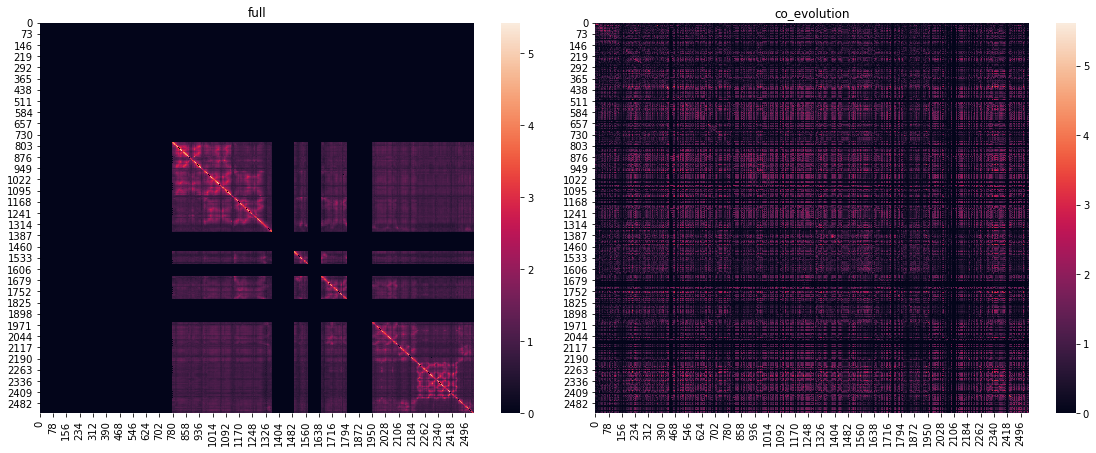

In [10]:
seqMatDict={}

nPlots=len(corrSeqData['Window'].unique())+1
nRow=int(np.ceil(np.sqrt(nPlots)))
nCol=int(np.ceil(1.*nPlots/nRow))

lowCut=0

fig,axs=plt.subplots(nCol,nRow)

fig.set_figwidth(16)
fig.set_figheight(.8*16.*nCol/nRow)

for iAx,window in enumerate(corrSeqData['Window'].unique()):
    print window,
    ax=axs.flat[iAx]
    testDat=corrSeqData[corrSeqData['Window']==window]

    testMat=np.array(sp.sparse.coo_matrix(
        (-np.log(1.-testDat['Corr']),
        (testDat['PDBresid_1'],testDat['PDBresid_2'])),
        shape=np.array(coEvoExcelData).shape).todense())

    testMat[np.nonzero(1-np.isfinite(testMat))]=0
    
    sns.heatmap(testMat,ax=ax,vmin=lowCut)
    ax.set_title(window)
    #plt.show()
    seqMatDict[window]=testMat

print 'co_evolution'
ax=axs.flat[iAx+1]
testDat=coEvoExcelData

testMat=np.matrix(np.array(coEvoExcelData))

sns.heatmap(testMat,ax=ax,vmin=lowCut)

ax.set_title('co_evolution')
plt.tight_layout()
plt.show()

/Users/wbotellosmith/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


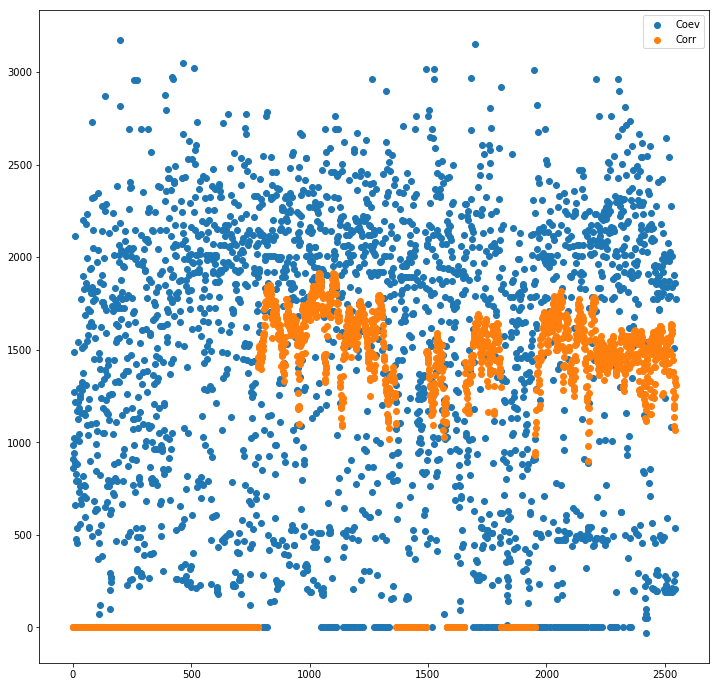

In [43]:
testDat=corrSeqData[corrSeqData['Window']==window]

testMat=np.array(sp.sparse.coo_matrix(
    (-np.log(1.-testDat['Corr']),
    (testDat['PDBresid_1'],testDat['PDBresid_2'])),
    shape=np.array(coEvoExcelData).shape).todense())
testMat[np.nonzero(1-np.isfinite(testMat))]=0

plt.figure(figsize=(12,12))
plt.scatter(np.arange(len(coEvoExcelData)),
            np.sum(np.array(coEvoExcelData),axis=0),
            label='Coev')
plt.scatter(np.arange(len(testMat)),
            np.sum(testMat,axis=0),label='Corr')
plt.legend()
plt.show()

In [ ]:
plt.plot(np.diag(np.array(coEvoExcelData)))
plt.show()

In [ ]:
plt.hist(np.array(testMat)[np.nonzero(testMat>np.quantile(testMat[np.nonzero(testMat)],q=.999995))])
plt.show()

In [ ]:
print len(list(np.array(testMat)[np.nonzero(testMat>np.quantile(testMat[np.nonzero(testMat)],q=.999995))]))
list(np.array(testMat)[np.nonzero(testMat>np.quantile(testMat[np.nonzero(testMat)],q=.999995))])

# Generate pdb resid - simulation resids back map

In [11]:
pdbResid_to_simResIndex={}
for simResIndex,pdbResid in enumerate(simResid_to_pdbResid):
    if pdbResid in pdbResid_to_simResIndex:
        pdbResid_to_simResIndex[pdbResid].append(simResIndex)
    else:
        pdbResid_to_simResIndex[pdbResid]=[simResIndex]
pdbResid_to_simResIndex

{782: [0, 1418, 2836],
 783: [1, 1419, 2837],
 784: [2, 1420, 2838],
 785: [3, 1421, 2839],
 786: [4, 1422, 2840],
 787: [5, 1423, 2841],
 788: [6, 1424, 2842],
 789: [7, 1425, 2843],
 790: [8, 1426, 2844],
 791: [9, 1427, 2845],
 792: [10, 1428, 2846],
 793: [11, 1429, 2847],
 794: [12, 1430, 2848],
 795: [13, 1431, 2849],
 796: [14, 1432, 2850],
 797: [15, 1433, 2851],
 798: [16, 1434, 2852],
 799: [17, 1435, 2853],
 800: [18, 1436, 2854],
 801: [19, 1437, 2855],
 802: [20, 1438, 2856],
 803: [21, 1439, 2857],
 804: [22, 1440, 2858],
 805: [23, 1441, 2859],
 806: [24, 1442, 2860],
 807: [25, 1443, 2861],
 808: [26, 1444, 2862],
 809: [27, 1445, 2863],
 810: [28, 1446, 2864],
 811: [29, 1447, 2865],
 812: [30, 1448, 2866],
 813: [31, 1449, 2867],
 814: [32, 1450, 2868],
 815: [33, 1451, 2869],
 816: [34, 1452, 2870],
 817: [35, 1453, 2871],
 818: [36, 1454, 2872],
 819: [37, 1455, 2873],
 820: [38, 1456, 2874],
 821: [39, 1457, 2875],
 822: [40, 1458, 2876],
 823: [41, 1459, 2877],
 8

# Compute high conserved residues and coevolving pairs

In [ ]:
highCoev_pdbIDs=np.array(testMat)[np.nonzero(testMat>np.quantile(testMat[np.nonzero(testMat)],q=.95))]
highCoev_simIDs=np.concatenate(map(
    lambda x: pdbResid_to_simResIndex[x] if (x in pdbResid_to_simResIndex) else [],
    highCoev_pdbIDs))
highCoev_simIDs

In [ ]:
highCoev_pdbIDs

In [ ]:
qCutPair=.99995
highCoev_PDBpairs=np.nonzero(testMat>np.quantile(testMat[np.nonzero(testMat)],q=qCutPair))

highCoev_SIMpairs=np.concatenate(
    [
        [(a,b) for a in pdbResid_to_simResIndex[pdbPair[0]] \
               for b in pdbResid_to_simResIndex[pdbPair[1]]] \
        for pdbPair in zip(highCoev_PDBpairs[0]+1,highCoev_PDBpairs[1]+1) \
        if (pdbPair[0] in pdbResid_to_simResIndex) & \
           (pdbPair[1] in pdbResid_to_simResIndex) & \
           (pdbPair[0] != pdbPair[1])
    ]
)
print highCoev_SIMpairs

qCutCons=.95
pdbResCons=np.diag(testMat)

highCons_PDBres=np.nonzero(pdbResCons>np.quantile(pdbResCons,q=qCutCons))
highCons_SIMres=np.concatenate(
    [
        pdbResid_to_simResIndex[pdbRes] \
        for pdbRes in highCons_PDBres[0]+1 \
        if pdbRes in pdbResid_to_simResIndex
    ]
)
print highCons_SIMres

In [ ]:
sns.distplot(pdbResCons[highCons_PDBres],bins=np.arange(0,6,.125),kde=False,norm_hist=False,rug=True)
sns.distplot(pdbResCons,bins=np.arange(0,6,.125),kde=False,norm_hist=False)
plt.show()

## explore quantile cutoff histograms for conserved residues

In [ ]:
@interact_manual
def plot_high_cons_hist(qCut=widgets.FloatSlider(
                            min=1e-5,max=.5,step=1e-5,
                            value=.5,readout_format='.5f'),
                        cutType=['Upper','Lower','Both'],
                        normHist=[True,False],
                        rug=[True,False],
                        kde=[True,False],
                        logScale=[True,False]):
    testMat=np.array(coEvoExcelData)
    plt.figure(figsize=(12,9))
    pdbResCons=np.diag(testMat)
    if cutType=='Upper':
        highCons_PDBres=np.nonzero(pdbResCons>np.quantile(pdbResCons,q=1-qCut))
    elif cutType=='Lower':
        highCons_PDBres=np.nonzero(pdbResCons<np.quantile(pdbResCons,q=qCut))
    else:
        highCons_PDBres=np.nonzero(
            (pdbResCons<np.quantile(pdbResCons,q=qCut/2.)) + \
            (pdbResCons>np.quantile(pdbResCons,q=1-qCut/2.)))
    
    print "N values: %d"%len(highCons_PDBres[0])
    #print highCons_SIMres
    sns.distplot(pdbResCons[highCons_PDBres],
                 bins=np.arange(0,6,.125),
                 kde=kde,
                 norm_hist=normHist,
                 rug=rug)
    sns.distplot(pdbResCons,
                 bins=np.arange(0,6,.125),
                 kde=kde,
                 norm_hist=normHist)
    if normHist | kde:
        yType='freq'
    else:
        yType='count'
    if logScale:
        plt.yscale('log',basey=10)
        plt.ylabel('log10(%s)'%yType)
    else:
        plt.ylabel('%s'%yType)
    plt.xlabel('Score')
    plt.xlim(0,np.max(pdbResCons))
    plt.show()

## Explore quantile cutoff histograms for coevolving pairs

In [ ]:
@interact_manual
def plot_high_coev_hist(qCut=widgets.FloatSlider(
                            min=1e-6,max=.5,step=1e-6,
                            value=.5,readout_format='.6f'),
                        cutType=['Upper','Lower','Both'],
                        normHist=[True,False],
                        rug=[True,False],
                        kde=[True,False],
                        logScale=[True,False]):
    
    coEvDat=np.array(coEvoExcelData)
    for ii in np.arange(np.min(coEvDat.shape)):
        coEvDat[ii,ii]=0
    coEvDat=coEvDat[np.nonzero(coEvDat)]
    if cutType=='Upper':
        highCons_PDBpairs=np.nonzero(coEvDat>np.quantile(coEvDat,q=1-qCut))
    elif cutType=='Lower':
        highCons_PDBpairs=np.nonzero(coEvDat<np.quantile(coEvDat,q=qCut))
    else:
        highCons_PDBpairs=np.nonzero(
            (coEvDat<np.quantile(coEvDat,q=qCut/2.)) + \
            (coEvDat>np.quantile(coEvDat,q=1-qCut/2.)))
    
    Nvals=len(highCons_PDBpairs[0])
    print "N values: %d"%Nvals
    
    useKde=kde
    if Nvals > 25000:
        useKde=False
    
    #print highCons_SIMres
    sns.distplot(coEvDat[highCons_PDBpairs],
                 bins=np.arange(0,6,.125),
                 kde=useKde,
                 norm_hist=normHist,
                 rug=rug)
    sns.distplot(coEvDat,
                 bins=np.arange(0,6,.125),
                 kde=useKde,
                 norm_hist=normHist)
    if normHist | useKde:
        yType='freq'
    else:
        yType='count'
    if logScale:
        plt.yscale('log',basey=10)
        plt.ylabel('log10(%s)'%yType)
    else:
        plt.ylabel('%s'%yType)
    plt.xlabel('Score')
    plt.xlim(0,np.max(coEvDat))
    plt.show()

# Extract highly conserved / coevolving residues and pairs

In [12]:
qRes=0.01


testMat=np.array(coEvoExcelData)
pdbResCons=np.diag(testMat)
highCons_PDBres=np.nonzero(pdbResCons>np.quantile(pdbResCons,q=1-qRes))[0]

highCons_SIMres=np.concatenate([
    pdbResid_to_simResIndex[pdbRes] \
    for pdbRes in highCons_PDBres \
    if pdbRes in pdbResid_to_simResIndex
])
print "Quantile: %.3e (upper)"%(qRes)
print "N highly conserved residue sequence IDs: %g; number in Sim: %g (%.3f%s)"%(
    len(highCons_PDBres),
    len(highCons_SIMres)/3,
    len(highCons_SIMres)/3.0/len(highCons_PDBres)*100.,
    '%')
print "N highly conserved residue simulation IDs: %g"%(
    len(highCons_SIMres))

Quantile: 1.000e-02 (upper)
N highly conserved residue sequence IDs: 24; number in Sim: 9 (37.500%)
N highly conserved residue simulation IDs: 27


In [13]:
qPair=.000015

coEvDat=np.array(coEvoExcelData)
for ii in np.arange(np.min(coEvDat.shape)):
    coEvDat[ii,ii]=0
coEvVals=coEvDat[np.nonzero(coEvDat)]
highCons_PDBpairs=np.nonzero(coEvDat>np.quantile(coEvVals,q=1-qPair))

highCons_SIMpairs=np.concatenate([
    [(a,b) \
     for a in pdbResid_to_simResIndex[pdbPair[0]] \
     for b in pdbResid_to_simResIndex[pdbPair[1]]]\
    for pdbPair in zip(highCons_PDBpairs[0],highCons_PDBpairs[1]) \
    if (pdbPair[0] in pdbResid_to_simResIndex) & \
       (pdbPair[1] in pdbResid_to_simResIndex)
])
print "Quantile: %.3e (upper)"%(qPair)
print "N highly conserved residue sequence IDs: %g; number in Sim: %g (%.3f%s)"%(
    len(highCons_PDBpairs[0]),
    len(highCons_SIMpairs)/3,
    len(highCons_SIMpairs)/3.0/len(highCons_PDBpairs[0])*100.,
    '%')
print "N highly conserved residue simulation IDs: %g"%(
    len(highCons_SIMpairs))

Quantile: 1.500e-05 (upper)
N highly conserved residue sequence IDs: 80; number in Sim: 66 (82.500%)
N highly conserved residue simulation IDs: 198


# Visualize high conservation / coevolution in 3D 
NOTE: requires NGLview, not colab Friendly!!!

In [14]:
import nglview as ngl
import pytraj as pt

In [15]:
strucPDBname='visualization_struc.pdb'
strucPDBpath='/'.join([dataDir,strucPDBname])
strucTraj=pt.load(strucPDBpath)
strucTraj

pytraj.Trajectory, 1 frames: 
Size: 0.000000 (GB)
<Topology: 70296 atoms, 4254 residues, 12 mols, PBC with box type = ortho>
           

In [16]:
def drawProtNetEdge(protStruc,resID1,resID2,ngViewOb,
                    frame=0,edgeColor=[.5,.5,.5],radius=1,
                    *shapeArgs,**shapeKwargs):
    crd1=pt.center_of_mass(protStruc,':%g@CA'%resID1)[frame]
    crd2=pt.center_of_mass(protStruc,':%g@CA'%resID2)[frame]
    
    
    resname1=protStruc.topology.residue(resID1-1).name
    resid1=protStruc.topology.residue(resID1-1).original_resid
    
    resname2=protStruc.topology.residue(resID2-1).name
    resid2=protStruc.topology.residue(resID2-1).original_resid
    edgeLabel='%s.%g-%s.%g (%g-%g)'%(
        resname1,resid1,resname2,resid2,
        resID1-1,resID2-2)
    
    return ngViewOb.shape.add_cylinder(
        list(crd1),list(crd2),edgeColor,radius,
        edgeLabel,
        *shapeArgs,**shapeKwargs)

def drawProtCorrMat(protStruc,corrMat,ngViewOb,
                    frame=0,colorsArray=None,radiiMat=None,
                    undirected=True):
    nzInds=np.nonzero(corrMat)
    edgeList=[]
    if not (radiiMat is None):
        radMat=radiiMat
    else:
        radMat=(np.abs(corrMat)>0)*.25
    if undirected:
        indArray=np.array([[ind[0],ind[1]] \
                            for ind in np.array([nzInds[0],nzInds[1]]).T \
                            if ind[0]<ind[1]])
    else:
        indArray=np.array([nzInds[0],nzInds[1]]).T
    for nzInd in indArray:
        if not (colorsArray is None):
            colorParm={'edgeColor':list(colorsArray[nzInd[0],nzInd[1],:])}
        else:
            colorParm={}
        edgeList.append(drawProtNetEdge(
            protStruc,nzInd[0]+1,nzInd[1]+1,
            ngViewOb,frame,radius=radMat[nzInd[0],nzInd[1]],
            **colorParm))
    return edgeList

In [ ]:
len(highCoev_SIMpairs)

In [17]:
print "Coevolution Quartile: %.4e (%g edges)"%(
    qPair,len(highCons_SIMpairs))
print "Conservation Quartile: %.4e (%g residues)"%(
    qRes,len(highCons_SIMres))
view=ngl.show_structure_file(strucPDBpath)
view.clear_representations()
view.add_representation('cartoon',alpha=.5,color='#777777')
for cRes in highCons_SIMres+1:
    view.add_representation('spacefill',selection='%g'%cRes,color='#FF00AA')
nPairs=0
for cPair in highCons_SIMpairs:
    if np.abs(cPair[0]-cPair[1])<(4254/3.):
        drawProtNetEdge(strucTraj,cPair[0]+1,cPair[1]+1,view,
                        edgeColor=[1.0,0.0,.75])
        nPairs=nPairs+1
print '%g same arm pairs'%nPairs
view

Coevolution Quartile: 1.5000e-05 (198 edges)
Conservation Quartile: 1.0000e-02 (27 residues)
110 same arm pairs


NGLWidget()

In [21]:
r2

1

In [26]:
qCorrPair=.0005
print "computing weight cutoff:",
corrCut=np.quantile(corrSeqData['Corr'].map(lambda x: -np.log(1-x) if (x < 1.0) else 0),q=1-qCorrPair)
print corrCut
print "extracting high correlation pairs"
highCorrData=corrSeqData[corrSeqData['Corr'].map(lambda x: -np.log(1-x) if (x < 1.0) else 0)>corrCut]
print("found %g pairs"%highCorrData.shape[0])
highCorrData.head()
print "Correlation Weight (-log(1-corr)) Quantile: %.4e (%g edges)"%(
    qPair,len(highCorrData))
highCorrPairs=zip(highCorrData['PDBresid_1'],highCorrData['PDBresid_2'])
print "Conservation Quartile: %.4e (%g residues)"%(
    qRes,len(highCons_SIMres))

###
qCoevPair=.000015

coEvDat=np.array(coEvoExcelData)
for ii in np.arange(np.min(coEvDat.shape)):
    coEvDat[ii,ii]=0
coEvVals=coEvDat[np.nonzero(coEvDat)]
highCons_PDBpairs=np.nonzero(coEvDat>np.quantile(coEvVals,q=1-qCoevPair))

highCons_SIMpairs=np.concatenate([
    [(a,b) \
     for a in [np.unique(np.array(pdbResid_to_simResIndex[pdbPair[0]])%(4254/3))] \
     for b in [np.unique(np.array(pdbResid_to_simResIndex[pdbPair[1]])%(4254/3))]]\
    for pdbPair in zip(highCons_PDBpairs[0],highCons_PDBpairs[1]) \
    if (pdbPair[0] in pdbResid_to_simResIndex) & \
       (pdbPair[1] in pdbResid_to_simResIndex)
])
print "Quantile: %.3e (upper)"%(qPair)
print "N highly conserved residue sequence IDs: %g; number in Sim: %g (%.3f%s)"%(
    len(highCons_PDBpairs[0]),
    len(highCons_SIMpairs)/3,
    len(highCons_SIMpairs)/3.0/len(highCons_PDBpairs[0])*100.,
    '%')
print "N highly conserved residue simulation IDs: %g"%(
    len(highCons_SIMpairs))

###

print "rendering structure in nglview"
view=ngl.show_structure_file(strucPDBpath)
view.clear_representations()
view.add_representation('cartoon',alpha=.5,color='#777777')
for cRes in highCons_SIMres+1:
    view.add_representation('spacefill',selection='%g'%cRes,color='#FF00AA')
nPairs=0
for cPair in highCorrPairs:
    #if np.abs(cPair[0]-cPair[1])<(4254/3.):
    #print "%g,%g"%(cPair[0],cPair[1])
    r1=pdbResid_to_simResIndex[cPair[0]][0]+1
    r2=pdbResid_to_simResIndex[cPair[1]][0]+1
    drawProtNetEdge(strucTraj,r1,r2,view,
                    edgeColor=[0.0,1.0,.75])
    nPairs=nPairs+1
print '%g same arm high correlation pairs'%nPairs

nPairs=0
for cPair in highCons_SIMpairs:
    if np.abs(cPair[0]-cPair[1])<(4254/3.):
        drawProtNetEdge(strucTraj,cPair[0]+1,cPair[1]+1,view,
                        edgeColor=[1.0,0.0,.75])
        nPairs=nPairs+1
print '%g same arm hi coevolving pairs'%nPairs
view

computing weight cutoff: 4.358610921543493
extracting high correlation pairs
found 1006 pairs
Correlation Weight (-log(1-corr)) Quantile: 5.0000e-04 (1006 edges)
Conservation Quartile: 1.0000e-02 (27 residues)
Quantile: 5.000e-04 (upper)
N highly conserved residue sequence IDs: 80; number in Sim: 7 (9.167%)
N highly conserved residue simulation IDs: 22
rendering structure in nglview
1006 same arm high correlation pairs
22 same arm hi coevolving pairs


NGLWidget()

## convenience mappers

In [27]:
@interact
def convert_simResid_to_sequence(simResid=widgets.IntSlider(
    min=1,max=len(simResid_to_pdbResid),step=1)):
    print(simResid_to_pdbResid[simResid-1])

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0xLCBkZXNjcmlwdGlvbj11J3NpbVJlc2lkJywgbWF4PTQyNTQsIG1pbj0xKSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXM9KHXigKY=


In [28]:
@interact
def convert_sequence_to_simResids(seqResid=widgets.IntSlider(
    min=1,max=np.max(pdbResid_to_simResIndex.keys()),step=1,value=782)):
    print(pdbResid_to_simResIndex[seqResid] if seqResid in pdbResid_to_simResIndex else 'Residue Not Found')

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT03ODIsIGRlc2NyaXB0aW9uPXUnc2VxUmVzaWQnLCBtYXg9MjU0NiwgbWluPTEpLCBPdXRwdXQoKSksIF9kb21fY2xhc3Nlcz3igKY=


In [ ]:
print(', '.join(map(str,
                    [res for res in highCons_PDBres if res in pdbResid_to_simResIndex])))